In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder

# Read data for X and y
df7 = pd.read_csv("../Data/Train/Random Samples/10000/Count based/7_countbased.csv")
df15 = pd.read_csv("../Data/Train/Random Samples/10000/Count based/15_countbased.csv")
df16 = pd.read_csv("../Data/Train/Random Samples/10000/Count based/16_countbased.csv")
df21 = pd.read_csv("../Data/Train/Random Samples/10000/Count based/21_countbased.csv")
df33 = pd.read_csv("../Data/Train/Random Samples/10000/Count based/33_countbased.csv")
df56 = pd.read_csv("../Data/Train/Random Samples/10000/Count based/56_countbased.csv")
df68 = pd.read_csv("../Data/Train/Random Samples/10000/Count based/68_countbased.csv")
df95 = pd.read_csv("../Data/Train/Random Samples/10000/Count based/95_countbased.csv")
df1000 = pd.read_csv("../Data/Train/Random Samples/10000/Count based/1000_countbased.csv")
df1001 = pd.read_csv("../Data/Train/Random Samples/10000/Count based/1001_countbased.csv")

df = pd.concat([df7,df15, df16, df21, df33, df56, df68, df95, df1000, df1001], ignore_index=True)

X = df.drop(columns=['y']).values
y = df['y'].values

In [19]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE

# Apply SMOTE to balance the dataset
sm = BorderlineSMOTE(k_neighbors=4, random_state=42)
X_res, y_res = sm.fit_resample(X, y)

#oversampler = RandomOverSampler(random_state=42)
#X_res, y_res = oversampler.fit_resample(X,y)

In [2]:
# Determine the number of unique critical error types
num_classes = len(np.unique(y))
print(num_classes)

# Encode the target variable using LabelEncoder and one-hot encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

10


In [21]:
# Assuming X_train and X_test are your input data arrays
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Assuming y_train and y_test are your label arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [18]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Add, GlobalAveragePooling1D, Dense

def residual_block(input_tensor, filters, kernel_size, strides=1):
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Downsample the input tensor if strides=2
    if strides == 2:
        input_tensor = Conv1D(filters, 1, strides=strides, padding='same')(input_tensor)
    
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

# Input layer
inputs = Input(shape=(77, 1))

# Initial convolution
x = Conv1D(64, 7, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Residual blocks
x = residual_block(x, 64, 3)
x = residual_block(x, 64, 3)
x = residual_block(x, 64, 3)

x = residual_block(x, 128, 3, strides=2)
x = residual_block(x, 128, 3)
x = residual_block(x, 128, 3)

x = residual_block(x, 256, 3, strides=2)
x = residual_block(x, 256, 3)
x = residual_block(x, 256, 3)

x = residual_block(x, 512, 3, strides=2)
x = residual_block(x, 512, 3)
x = residual_block(x, 512, 3)

# Global average pooling
x = GlobalAveragePooling1D()(x)

# Output layer
outputs = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 77, 1)]      0           []                               
                                                                                                  
 conv1d_105 (Conv1D)            (None, 77, 64)       512         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 77, 64)      256         ['conv1d_105[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 77, 64)       0           ['batch_normalization_94[0]

In [19]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=3,
                                        restore_best_weights=True)

In [20]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[earlystopping])

Epoch 1/50
151/151 [==============================] - 190s 1s/step - loss: 1.6707 - accuracy: 0.4035 - val_loss: 1.7149 - val_accuracy: 0.3128
Epoch 2/50
151/151 [==============================] - 160s 1s/step - loss: 1.3135 - accuracy: 0.4891 - val_loss: 1.3196 - val_accuracy: 0.4806
Epoch 3/50
151/151 [==============================] - 163s 1s/step - loss: 1.2412 - accuracy: 0.5034 - val_loss: 1.4148 - val_accuracy: 0.4928
Epoch 4/50
151/151 [==============================] - 159s 1s/step - loss: 1.2210 - accuracy: 0.5146 - val_loss: 1.2911 - val_accuracy: 0.5097
Epoch 5/50
151/151 [==============================] - 163s 1s/step - loss: 1.1745 - accuracy: 0.5323 - val_loss: 1.2742 - val_accuracy: 0.4975
Epoch 6/50
151/151 [==============================] - 160s 1s/step - loss: 1.1444 - accuracy: 0.5348 - val_loss: 1.1941 - val_accuracy: 0.5257
Epoch 7/50
151/151 [==============================] - 155s 1s/step - loss: 1.1292 - accuracy: 0.5425 - val_loss: 1.2207 - val_accuracy: 0.5299

In [15]:
import numpy as np
y_pred = model.predict(X_test)

y_pred_classes = []
y_real_classes = []

for item in y_pred:
    y_pred_classes.append(np.argmax(item))

for item in y_test:
    y_real_classes.append(np.argmax(item))
    
print(y_pred_classes[0])
print(y_real_classes[0])
# Assuming your classes are labeled from 0 to 25
predicted_class = np.argmax(y_pred[0])
probability = y_pred[0][predicted_class]

print("Predicted class:", predicted_class)
print("Probability:", probability)

75/75 [==============================] - 2s 23ms/step
1
1
Predicted class: 1
Probability: 0.99665076


In [16]:
import numpy as np
from sklearn.metrics import classification_report

print(classification_report(y_real_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.66      0.92      0.77       338
           1       0.73      0.75      0.74       191
           2       0.88      0.71      0.79        94
           3       0.00      0.00      0.00        40
           4       0.29      0.01      0.01       331
           5       0.52      0.54      0.53       317
           6       0.33      0.68      0.44       327
           7       0.26      0.34      0.30        88
           8       0.72      0.62      0.67       322
           9       0.33      0.23      0.27       324

    accuracy                           0.51      2372
   macro avg       0.47      0.48      0.45      2372
weighted avg       0.49      0.51      0.47      2372



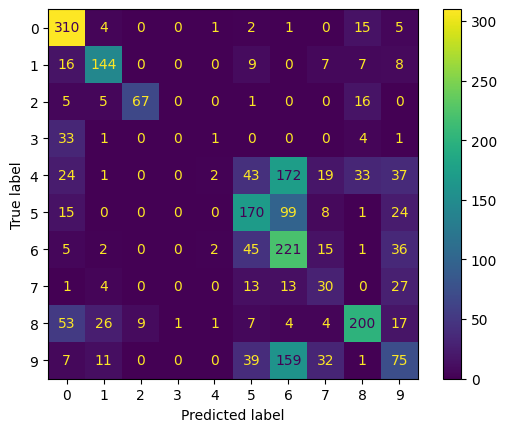

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_real_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()